In [9]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, Reshape, BatchNormalization, GRU, Bidirectional, Input, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import time
import pandas as pd

In [10]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Check for GPU availability
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print(f"GPU is available: {len(gpus)} GPU(s) detected")
    for gpu in gpus:
        print(f"  {gpu}")
    # Memory growth needs to be enabled to prevent TF from allocating all GPU memory
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU detected. Using CPU.")


No GPU detected. Using CPU.


In [11]:
# Data augmentation functions
def add_noise(feature):
    """Add random noise to the feature"""
    noise_ratio = 0.05
    noise_std = noise_ratio * np.max(np.abs(feature))
    noise = np.random.normal(0, noise_std, feature.shape)
    return feature + noise

def time_shift(feature):
    """Apply time shifting to the feature"""
    shift_amount = 0.1
    shift_samples = int(shift_amount * feature.shape[0])
    return np.roll(feature, shift_samples, axis=0)

def increase_volume(feature):
    """Increase the volume of the feature"""
    gain_factor = 1.5
    return np.clip(feature * gain_factor, -1.0, 1.0)

def reduce_volume(feature):
    """Reduce the volume of the feature"""
    reduction_factor = 0.5
    return feature * reduction_factor

def augment_audio_data(features, labels, augmentation_factor=1):
    """Apply multiple augmentation techniques to balance the dataset"""
    print("Applying data augmentation...")
    augmented_features = []
    augmented_labels = []
    
    # Count samples per class
    unique_labels = np.unique(labels)
    label_counts = {label: sum(1 for l in labels if l == label) for label in unique_labels}
    max_count = max(label_counts.values())
    
    # For each label, apply augmentation to balance classes
    for label in unique_labels:
        # Get indices of samples with this label
        indices = [i for i, l in enumerate(labels) if l == label]
        
        # Calculate how many augmented samples we need
        needed_samples = max_count - label_counts[label]
        
        # Add original samples
        for idx in indices:
            augmented_features.append(features[idx])
            augmented_labels.append(label)
        
        # Add augmented samples if needed
        if needed_samples > 0:
            # Cycle through indices multiple times if necessary
            for i in range(needed_samples):
                idx = indices[i % len(indices)]
                feature = features[idx]
                
                # Apply a random augmentation technique
                aug_type = np.random.choice(['noise', 'shift', 'volume_up', 'volume_down'])
                
                if aug_type == 'noise':
                    augmented_feature = add_noise(feature)
                elif aug_type == 'shift':
                    augmented_feature = time_shift(feature)
                elif aug_type == 'volume_up':
                    augmented_feature = increase_volume(feature)
                else:
                    augmented_feature = reduce_volume(feature)
                
                augmented_features.append(augmented_feature)
                augmented_labels.append(label)
    
    return np.array(augmented_features), np.array(augmented_labels)


In [12]:
# Function to load and preprocess audio files
def load_audio_files(data_path, n_mfcc=40, max_files_per_emotion=None):
    """Enhanced feature extraction with multiple acoustic features"""
    features = []
    labels = []
    file_paths = []
    
    print("Loading audio files...")
    
    # Dictionary to count files per emotion
    emotion_counts = {}
    
    for actor in os.listdir(data_path):
        actor_path = os.path.join(data_path, actor)
        if os.path.isdir(actor_path):
            for file in os.listdir(actor_path):
                if file.endswith(".wav"):
                    # Extract emotion from filename
                    emotion = file.split('-')[2]
                    
                    # Count files per emotion
                    if max_files_per_emotion:
                        if emotion not in emotion_counts:
                            emotion_counts[emotion] = 0
                        if emotion_counts[emotion] >= max_files_per_emotion:
                            continue
                        emotion_counts[emotion] += 1
                    
                    file_path = os.path.join(actor_path, file)
                    file_paths.append(file_path)
                    labels.append(emotion)
    
    # Process audio files
    for i, file_path in enumerate(file_paths):
        if i % 100 == 0:
            print(f"Processing file {i+1}/{len(file_paths)}")
        
        # Load audio file
        signal, sr = librosa.load(file_path, sr=22050)
        
        # Extract multiple features
        mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
        
        # Normalize MFCCs
        mfccs = (mfccs - np.mean(mfccs)) / (np.std(mfccs) + 1e-10)
        
        features.append(mfccs.T)  # Transpose to get time as first dimension
    
    print(f"Loaded {len(features)} audio files")
    return features, labels, file_paths

# Function to visualize audio data
def visualize_audio(file_path, save_path=None):
    # Load audio
    signal, sr = librosa.load(file_path, sr=22050)
    
    plt.figure(figsize=(15, 10))
    
    # Plot waveform
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(signal, sr=sr)
    plt.title('Waveform')
    
    # Plot spectrogram
    plt.subplot(3, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    
    # Plot MFCCs
    plt.subplot(3, 1, 3)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title('MFCCs')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

# Function to pad sequences to the same length
def pad_sequences(features, max_len=None):
    if max_len is None:
        max_len = max(len(feature) for feature in features)
    
    features_padded = np.array([
        np.pad(f, ((0, max_len - len(f)), (0, 0)), mode='constant') 
        if len(f) < max_len else f[:max_len] 
        for f in features
    ])
    
    return features_padded, max_len


In [15]:
# Improved CNN-LSTM model
class ImprovedEmotionCNNLSTM(Model):
    def __init__(self, input_shape, num_classes):
        super(ImprovedEmotionCNNLSTM, self).__init__()
        # CNN layers for feature extraction
        self.conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.bn1 = BatchNormalization()
        self.pool1 = MaxPooling2D((2, 2))
        self.dropout1 = Dropout(0.2)
        
        self.conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')
        self.bn2 = BatchNormalization()
        self.pool2 = MaxPooling2D((2, 2))
        self.dropout2 = Dropout(0.3)
        
        # Flatten and dense layer
        self.flatten = Flatten()
        self.dense1 = Dense(256, activation='relu')
        self.bn3 = BatchNormalization()
        self.dropout3 = Dropout(0.4)
        
        # Reshape for LSTM
        self.reshape = Reshape((1, -1))
        
        # Dual-layer LSTM
        self.lstm1 = Bidirectional(LSTM(128, return_sequences=True, 
                                       recurrent_dropout=0.2,
                                       kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
        self.bn4 = BatchNormalization()
        self.lstm2 = Bidirectional(LSTM(64, return_sequences=False,
                                       recurrent_dropout=0.2,
                                       kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
        # Output layer
        self.dense2 = Dense(128, activation='relu')
        self.bn5 = BatchNormalization()
        self.dropout4 = Dropout(0.4)
        self.dense3 = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.pool1(x)
        x = self.dropout1(x, training=training)
        
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.pool2(x)
        x = self.dropout2(x, training=training)
        
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.bn3(x, training=training)
        x = self.dropout3(x, training=training)
        
        x = self.reshape(x)
        x = self.lstm1(x)
        x = self.bn4(x, training=training)
        x = self.lstm2(x)
        
        x = self.dense2(x)
        x = self.bn5(x, training=training)
        x = self.dropout4(x, training=training)
        return self.dense3(x)

# Improved CNN-GRU model
class ImprovedEmotionCNNGRU(Model):
    def __init__(self, input_shape, num_classes):
        super(ImprovedEmotionCNNGRU, self).__init__()
        # CNN layers with more filters
        self.conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.bn1 = BatchNormalization()
        self.pool1 = MaxPooling2D((2, 2))
        self.dropout1 = Dropout(0.2)
        
        self.conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')
        self.bn2 = BatchNormalization()
        self.pool2 = MaxPooling2D((2, 2))
        self.dropout2 = Dropout(0.3)
        
        # Additional conv layer
        self.conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')
        self.bn3 = BatchNormalization()
        self.pool3 = MaxPooling2D((2, 2))
        self.dropout3 = Dropout(0.4)
        
        # Flatten and dense
        self.flatten = Flatten()
        self.dense1 = Dense(256, activation='relu')
        self.bn4 = BatchNormalization()
        self.dropout4 = Dropout(0.4)
        
        # Reshape for GRU
        self.reshape = Reshape((1, -1))
        
        # Stacked GRU layers
        self.gru1 = Bidirectional(GRU(128, return_sequences=True,
                                     recurrent_dropout=0.2,
                                     kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
        self.bn5 = BatchNormalization()
        self.gru2 = Bidirectional(GRU(64, return_sequences=False,
                                     recurrent_dropout=0.2,
                                     kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
        
        # Output layers
        self.dense2 = Dense(128, activation='relu')
        self.bn6 = BatchNormalization()
        self.dropout5 = Dropout(0.4)
        self.dense3 = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.pool1(x)
        x = self.dropout1(x, training=training)
        
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.pool2(x)
        x = self.dropout2(x, training=training)
        
        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = self.pool3(x)
        x = self.dropout3(x, training=training)
        
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.bn4(x, training=training)
        x = self.dropout4(x, training=training)
        
        x = self.reshape(x)
        x = self.gru1(x)
        x = self.bn5(x, training=training)
        x = self.gru2(x)
        
        x = self.dense2(x)
        x = self.bn6(x, training=training)
        x = self.dropout5(x, training=training)
        return self.dense3(x)

# Improved Pure CNN model with deeper architecture
class ImprovedEmotionPureCNN(Model):
    def __init__(self, input_shape, num_classes):
        super(ImprovedEmotionPureCNN, self).__init__()
        # CNN layers
        self.conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.bn1 = BatchNormalization()
        self.pool1 = MaxPooling2D((2, 2))
        self.dropout1 = Dropout(0.2)
        
        self.conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')
        self.bn2 = BatchNormalization()
        self.pool2 = MaxPooling2D((2, 2))
        self.dropout2 = Dropout(0.3)
        
        self.conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')
        self.bn3 = BatchNormalization()
        self.pool3 = MaxPooling2D((2, 2))
        self.dropout3 = Dropout(0.4)
        
        self.conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')
        self.bn4 = BatchNormalization()
        self.pool4 = MaxPooling2D((2, 2))
        self.dropout4 = Dropout(0.4)
        
        # Flatten and dense layers
        self.flatten = Flatten()
        self.dense1 = Dense(512, activation='relu')
        self.bn5 = BatchNormalization()
        self.dropout5 = Dropout(0.5)
        
        self.dense2 = Dense(256, activation='relu')
        self.bn6 = BatchNormalization()
        self.dropout6 = Dropout(0.5)
        
        self.dense3 = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.pool1(x)
        x = self.dropout1(x, training=training)
        
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.pool2(x)
        x = self.dropout2(x, training=training)
        
        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = self.pool3(x)
        x = self.dropout3(x, training=training)
        
        x = self.conv4(x)
        x = self.bn4(x, training=training)
        x = self.pool4(x)
        x = self.dropout4(x, training=training)
        
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.bn5(x, training=training)
        x = self.dropout5(x, training=training)
        
        x = self.dense2(x)
        x = self.bn6(x, training=training)
        x = self.dropout6(x, training=training)
        return self.dense3(x)

        

In [ ]:

# Function to create and compile model
def create_model(model_type, input_shape, num_classes):
    if model_type == 'cnn':
        model = Sequential([
            Input(shape=input_shape),
            # CNN layers
            Conv2D(32, (3, 3), padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.2),
            
            Conv2D(64, (3, 3), padding='same', activation='relu'),
            BatchNormalization(),# Function to calculate class weights
def calculate_class_weights(labels):
    """Calculate class weights for imbalanced dataset"""
    unique_labels = np.unique(labels)
    class_weights = {}
    total_samples = len(labels)
    
    # Count samples per class
    for i, label in enumerate(unique_labels):
        count = np.sum(labels == i)
        # Inverse frequency weighting
        class_weights[i] = total_samples / (len(unique_labels) * count)
    
    return class_weights

# Function to train and evaluate model with more detailed metrics
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name, 
                      epochs=50, batch_size=32, class_weights=None):
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,  # Increased patience
        restore_best_weights=True,
        verbose=1
    )
    
    model_checkpoint = ModelCheckpoint(
        f'models/{model_name}.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=8,
        min_lr=0.00001,  # Lower minimum learning rate
        verbose=1
    )
    
    # Start timer
    start_time = time.time()
    
    # Train model with class weights if provided
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        class_weight=class_weights,
        verbose=1
    )
    
    # End timer
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Evaluate model
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}")
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'visualizations/{model_name}_history.png')
    plt.show()
    
    # Confusion matrix
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(f'visualizations/{model_name}_confusion_matrix.png')
    plt.show()
    
    # Classification report
    report = classification_report(y_true_classes, y_pred_classes, 
                                  target_names=label_encoder.classes_, 
                                  output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print(report_df)
    
    # Per-class accuracy
    class_accuracy = {}
    for i, class_name in enumerate(label_encoder.classes_):
        class_indices = np.where(y_true_classes == i)[0]
        if len(class_indices) > 0:
            class_acc = np.mean(y_pred_classes[class_indices] == i)
            class_accuracy[class_name] = class_acc
    
    print("\nPer-class accuracy:")
    for class_name, acc in class_accuracy.items():
        print(f"{class_name}: {acc:.4f}")
    
    return history, model


In [5]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name, epochs=50, batch_size=32):
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    model_checkpoint = ModelCheckpoint(
        f'models/{model_name}.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001,
        verbose=1
    )
    
    # Start timer
    start_time = time.time()
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        verbose=1
    )
    
    # End timer
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Evaluate model
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}")
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'visualizations/{model_name}_history.png')
    plt.show()
    
    # Confusion matrix
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(f'visualizations/{model_name}_confusion_matrix.png')
    plt.show()
    
    # Classification report
    report = classification_report(y_true_classes, y_pred_classes, 
                                  target_names=label_encoder.classes_, 
                                  output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print(report_df)
    
    return history, model

In [16]:
# Main execution
if __name__ == "__main__":
    # Set data path
    data_path = "./Audio_Speech_Actors_01-24"  # Change to actual dataset path
    
    # Step 1: Load and preprocess data
    features, labels, file_paths = load_audio_files(data_path, n_mfcc=40)
    
    # Step 2: Print class distribution
    unique_labels = np.unique(labels)
    print("\nClass distribution before augmentation:")
    for label in unique_labels:
        count = sum(1 for l in labels if l == label)
        print(f"Emotion {label}: {count} samples")
    
    # Step 3: Visualize some examples
    print("\nGenerating audio visualizations...")
    for emotion in unique_labels:
        # Find an example of this emotion
        for i, label in enumerate(labels):
            if label == emotion:
                visualize_audio(file_paths[i], 
                               save_path=f'visualizations/example_{emotion}.png')
                print(f"Created visualization for emotion: {emotion}")
                break
    
    # Step 4: Encode labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    num_classes = len(label_encoder.classes_)
    
    print(f"\nEmotion classes: {label_encoder.classes_}")
    
    # Step 5: Apply data augmentation to balance classes
    features_np = np.array(features, dtype=object)  # Convert to numpy array
    augmented_features, augmented_labels = augment_audio_data(features_np, encoded_labels)
    
    # Print class distribution after augmentation
    print("\nClass distribution after augmentation:")
    unique_labels = np.unique(augmented_labels)
    for label in unique_labels:
        count = sum(1 for l in augmented_labels if l == label)
        print(f"Emotion {label_encoder.classes_[label]}: {count} samples")
    
    # Step 6: Convert to one-hot encoding
    one_hot_labels = to_categorical(augmented_labels, num_classes=num_classes)
    
    # Step 7: Pad sequences
    features_padded, max_len = pad_sequences(augmented_features)
    
    # Step 8: Reshape for CNN input
    features_padded = np.expand_dims(features_padded, axis=-1)  # Add channel dimension
    
    # Step 9: Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        features_padded, one_hot_labels, test_size=0.2, random_state=42, stratify=augmented_labels
    )
    
    print(f"\nTraining set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    
    # Calculate class weights from original distribution
    class_weights = calculate_class_weights(encoded_labels)
    print("\nClass weights:")
    for i, weight in class_weights.items():
        print(f"Class {label_encoder.classes_[i]}: {weight:.4f}")
    
    # Step 10: Create and train models
    input_shape = X_train.shape[1:]  # (Time, Features, Channel)
    
    # Improved LSTM model
    print("\n=== Training Improved LSTM Model ===")
    lstm_model = ImprovedEmotionCNNLSTM(input_shape, num_classes)
    lstm_model.build(input_shape=(None,) + input_shape)
    lstm_model.summary()
    
    # Use a slower learning rate for LSTM
    lstm_model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    lstm_history, lstm_model = train_and_evaluate(
        lstm_model, X_train, y_train, X_test, y_test, 
        'improved_lstm_model', epochs=100, batch_size=32, 
        class_weights=class_weights
    )
    
    # Improved GRU model
    print("\n=== Training Improved GRU Model ===")
    gru_model = ImprovedEmotionCNNGRU(input_shape, num_classes)
    gru_model.build(input_shape=(None,) + input_shape)
    gru_model.summary()
    
    # Use a slower learning rate for GRU
    gru_model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    gru_history, gru_model = train_and_evaluate(
        gru_model, X_train, y_train, X_test, y_test, 
        'improved_gru_model', epochs=100, batch_size=32,
        class_weights=class_weights
    )
    
    # Improved Pure CNN model
    print("\n=== Training Improved Pure CNN Model ===")
    cnn_model = ImprovedEmotionPureCNN(input_shape, num_classes)
    cnn_model.build(input_shape=(None,) + input_shape)
    cnn_model.summary()
    
    cnn_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    cnn_history, cnn_model = train_and_evaluate(
        cnn_model, X_train, y_train, X_test, y_test, 
        'improved_cnn_model', epochs=100, batch_size=32,
        class_weights=class_weights
    )
    
    # Step 11: Compare models
    models = {
        'CNN': max(cnn_history.history['val_accuracy']),
        'LSTM': max(lstm_history.history['val_accuracy']),
        'GRU': max(gru_history.history['val_accuracy'])
    }
    
    best_model = max(models, key=models.get)
    print(f"\nBest model: {best_model} with validation accuracy: {models[best_model]:.4f}")
    
    # Plot comparison
    plt.figure(figsize=(12, 5))
    
    # Accuracy comparison
    plt.subplot(1, 2, 1)
    plt.plot(cnn_history.history['val_accuracy'], label='CNN')
    plt.plot(lstm_history.history['val_accuracy'], label='LSTM')
    plt.plot(gru_history.history['val_accuracy'], label='GRU')
    plt.title('Model Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss comparison
    plt.subplot(1, 2, 2)
    plt.plot(cnn_history.history['val_loss'], label='CNN')
    plt.plot(lstm_history.history['val_loss'], label='LSTM')
    plt.plot(gru_history.history['val_loss'], label='GRU')
    plt.title('Model Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('visualizations/model_comparison.png')
    plt.show()
    
    print("\nSpeech Emotion Recognition project completed successfully!")

Loading audio files...
Processing file 1/1440
Processing file 101/1440
Processing file 201/1440
Processing file 301/1440
Processing file 401/1440
Processing file 501/1440
Processing file 601/1440
Processing file 701/1440
Processing file 801/1440
Processing file 901/1440
Processing file 1001/1440
Processing file 1101/1440
Processing file 1201/1440
Processing file 1301/1440
Processing file 1401/1440
Loaded 1440 audio files

Class distribution before augmentation:
Emotion 01: 96 samples
Emotion 02: 192 samples
Emotion 03: 192 samples
Emotion 04: 192 samples
Emotion 05: 192 samples
Emotion 06: 192 samples
Emotion 07: 192 samples
Emotion 08: 192 samples

Generating audio visualizations...
Created visualization for emotion: 01
Created visualization for emotion: 02
Created visualization for emotion: 03
Created visualization for emotion: 04
Created visualization for emotion: 05
Created visualization for emotion: 06
Created visualization for emotion: 07
Created visualization for emotion: 08

Em

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1536,) + inhomogeneous part.

Loading audio files...
Processing file 1/1440
Processing file 101/1440
Processing file 201/1440
Processing file 301/1440
Processing file 401/1440
Processing file 501/1440
Processing file 601/1440
Processing file 701/1440
Processing file 801/1440
Processing file 901/1440
Processing file 1001/1440
Processing file 1101/1440
Processing file 1201/1440
Processing file 1301/1440
Processing file 1401/1440
Loaded 1440 audio files
Generating audio visualizations...
Created visualization for emotion: 08
Created visualization for emotion: 02
Created visualization for emotion: 01
Created visualization for emotion: 04
Created visualization for emotion: 07
Created visualization for emotion: 06
Created visualization for emotion: 03
Created visualization for emotion: 05
Emotion classes: ['01' '02' '03' '04' '05' '06' '07' '08']
Training set shape: (1152, 228, 40, 1)
Testing set shape: (288, 228, 40, 1)

=== Training CNN Model ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 228, 40, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 228, 40, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 114, 20, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 114, 20, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 114, 20, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 114, 20, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 57, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 57, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 57, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 57, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 5, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 5, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 17920)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,587,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,684,424 (17.87 MB)

 Trainable params: 4,683,464 (17.87 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.2526 - loss: 2.5995
Epoch 1: val_accuracy improved from -inf to 0.13194, saving model to models/cnn_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 272ms/step - accuracy: 0.2535 - loss: 2.5905 - val_accuracy: 0.1319 - val_loss: 3.4906 - learning_rate: 0.0010
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.3707 - loss: 1.8547
Epoch 2: val_accuracy did not improve from 0.13194
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.3713 - loss: 1.8513 - val_accuracy: 0.1319 - val_loss: 4.8869 - learning_rate: 0.0010
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.3909 - loss: 1.6588
Epoch 3: val_accuracy did not improve from 0.13194
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - accuracy: 0.3920 - loss: 1.6567 - val_accuracy: 0.1319 - val_loss: 5.6005 - learning_rate: 0.0010
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.5217 - loss: 1.3665
Epoch 4: val_accuracy did not improve from 0.13194
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - accuracy: 0.5216 - loss: 1.3654 - val_accuracy: 0.1319 - val_loss: 5.8196 - learning_rate: 0.0010
Epoch 5/30
36/36 ━━━━━━━

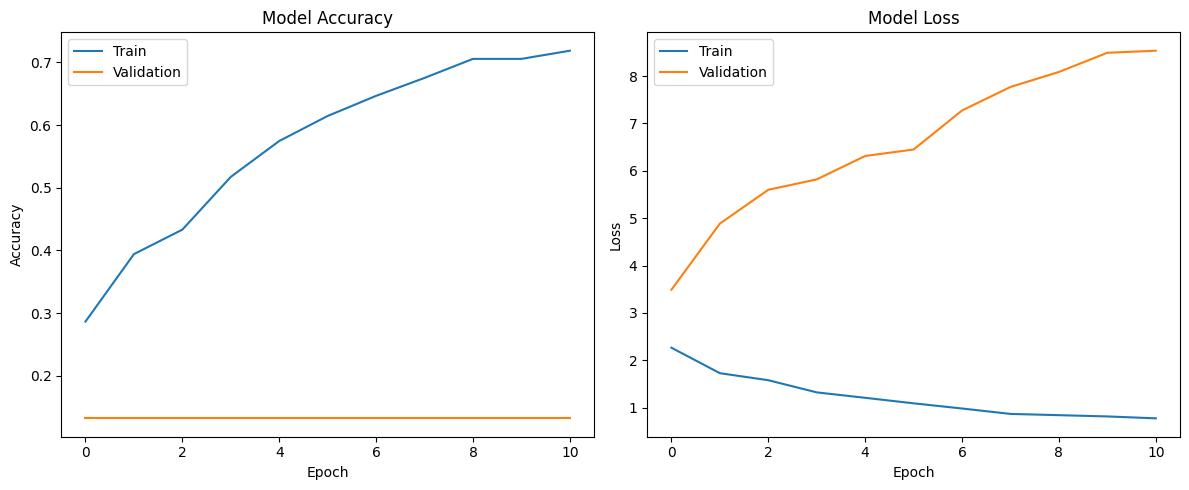

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


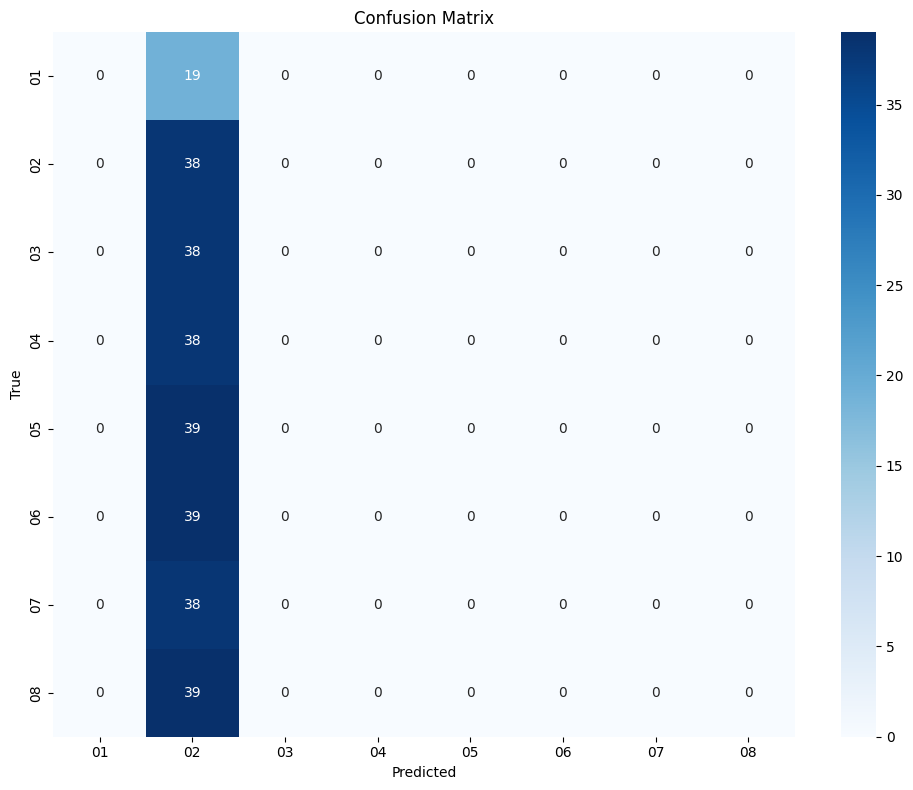

              precision    recall  f1-score     support
01             0.000000  0.000000  0.000000   19.000000
02             0.131944  1.000000  0.233129   38.000000
03             0.000000  0.000000  0.000000   38.000000
04             0.000000  0.000000  0.000000   38.000000
05             0.000000  0.000000  0.000000   39.000000
06             0.000000  0.000000  0.000000   39.000000
07             0.000000  0.000000  0.000000   38.000000
08             0.000000  0.000000  0.000000   39.000000
accuracy       0.131944  0.131944  0.131944    0.131944
macro avg      0.016493  0.125000  0.029141  288.000000
weighted avg   0.017409  0.131944  0.030760  288.000000

=== Training LSTM Model ===


c:\Users\anujk\Documents\MIT\MIT3Year\DL_Lab\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anujk\Documents\MIT\MIT3Year\DL_Lab\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anujk\Documents\MIT\MIT3Year\DL_Lab\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 228, 40, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 228, 40, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 114, 20, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 114, 20, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 114, 20, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 57, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,669,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,788,616 (18.27 MB)

 Trainable params: 4,788,424 (18.27 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.1260 - loss: 2.1565
Epoch 1: val_accuracy improved from -inf to 0.14236, saving model to models/lstm_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step - accuracy: 0.1264 - loss: 2.1558 - val_accuracy: 0.1424 - val_loss: 2.0726 - learning_rate: 0.0010
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.1509 - loss: 2.1080
Epoch 2: val_accuracy improved from 0.14236 to 0.17014, saving model to models/lstm_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 224ms/step - accuracy: 0.1508 - loss: 2.1081 - val_accuracy: 0.1701 - val_loss: 2.0713 - learning_rate: 0.0010
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.1466 - loss: 2.0925
Epoch 3: val_accuracy did not improve from 0.17014
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.1469 - loss: 2.0924 - val_accuracy: 0.1493 - val_loss: 2.0693 - learning_rate: 0.0010
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.1830 - loss: 2.0298
Epoch 4: val_accuracy did not improve from 0.17014
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.1834 - loss: 2.0298 - val_accuracy: 0.1354 - val_loss: 2.0694 - learning_rate: 0.0010
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.1661 - loss: 2.0602
Epoch 5: val_accuracy did not improve from 0.17014
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.1671 - loss: 2.0590 - val_accuracy: 0.1319 - val_loss: 2.0749 - learning_rate: 0.0010
Epoch 6/30
36/36 ━━━━━━━━

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.2178 - loss: 1.9264 - val_accuracy: 0.1806 - val_loss: 2.0848 - learning_rate: 0.0010
Epoch 10/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.2561 - loss: 1.8897
Epoch 10: val_accuracy improved from 0.18056 to 0.20486, saving model to models/lstm_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - accuracy: 0.2561 - loss: 1.8895 - val_accuracy: 0.2049 - val_loss: 2.0789 - learning_rate: 0.0010
Epoch 11/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.2566 - loss: 1.8789
Epoch 11: val_accuracy did not improve from 0.20486
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 0.2571 - loss: 1.8782 - val_accuracy: 0.1979 - val_loss: 2.0513 - learning_rate: 0.0010
Epoch 12/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.2701 - loss: 1.8293
Epoch 12: val_accuracy improved from 0.20486 to 0.24306, saving model to models/lstm_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.2704 - loss: 1.8293 - val_accuracy: 0.2431 - val_loss: 2.0164 - learning_rate: 0.0010
Epoch 13/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.2698 - loss: 1.8389
Epoch 13: val_accuracy improved from 0.24306 to 0.25347, saving model to models/lstm_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.2701 - loss: 1.8388 - val_accuracy: 0.2535 - val_loss: 1.9708 - learning_rate: 0.0010
Epoch 14/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.2693 - loss: 1.8294
Epoch 14: val_accuracy did not improve from 0.25347
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - accuracy: 0.2699 - loss: 1.8285 - val_accuracy: 0.2431 - val_loss: 1.9460 - learning_rate: 0.0010
Epoch 15/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.3065 - loss: 1.7939
Epoch 15: val_accuracy did not improve from 0.25347
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.3063 - loss: 1.7937 - val_accuracy: 0.2257 - val_loss: 2.0636 - learning_rate: 0.0010
Epoch 16/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.3046 - loss: 1.7807
Epoch 16: val_accuracy did not improve from 0.25347
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.3047 - loss: 1.7801 - val_accuracy: 0.2361 - val_loss: 2.0152 - learning_rate: 0.0010
Epoch 17/30
36/36 ━

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.2769 - loss: 1.7671 - val_accuracy: 0.3576 - val_loss: 1.7647 - learning_rate: 0.0010
Epoch 19/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.3322 - loss: 1.7240
Epoch 19: val_accuracy did not improve from 0.35764
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.3324 - loss: 1.7235 - val_accuracy: 0.2743 - val_loss: 1.9300 - learning_rate: 0.0010
Epoch 20/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.3139 - loss: 1.7367
Epoch 20: val_accuracy improved from 0.35764 to 0.37847, saving model to models/lstm_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 0.3143 - loss: 1.7360 - val_accuracy: 0.3785 - val_loss: 1.6904 - learning_rate: 0.0010
Epoch 21/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.3217 - loss: 1.6571
Epoch 21: val_accuracy did not improve from 0.37847
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 0.3219 - loss: 1.6572 - val_accuracy: 0.3472 - val_loss: 1.6528 - learning_rate: 0.0010
Epoch 22/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.3347 - loss: 1.7111
Epoch 22: val_accuracy did not improve from 0.37847
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.3350 - loss: 1.7102 - val_accuracy: 0.2951 - val_loss: 1.7921 - learning_rate: 0.0010
Epoch 23/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.3312 - loss: 1.6867
Epoch 23: val_accuracy did not improve from 0.37847
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 0.3317 - loss: 1.6863 - val_accuracy: 0.3681 - val_loss: 1.6614 - learning_rate: 0.0010
Epoch 24/30
36/36 ━

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.3293 - loss: 1.7139 - val_accuracy: 0.3993 - val_loss: 1.6182 - learning_rate: 0.0010
Epoch 28/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.3283 - loss: 1.6797
Epoch 28: val_accuracy improved from 0.39931 to 0.42014, saving model to models/lstm_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 0.3291 - loss: 1.6784 - val_accuracy: 0.4201 - val_loss: 1.6542 - learning_rate: 0.0010
Epoch 29/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.3311 - loss: 1.6666
Epoch 29: val_accuracy did not improve from 0.42014
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.3320 - loss: 1.6651 - val_accuracy: 0.4167 - val_loss: 1.6031 - learning_rate: 0.0010
Epoch 30/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.3519 - loss: 1.6511
Epoch 30: val_accuracy did not improve from 0.42014
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.3523 - loss: 1.6510 - val_accuracy: 0.3438 - val_loss: 1.6586 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 29.
Training completed in 236.52 seconds
Test accuracy: 0.4167


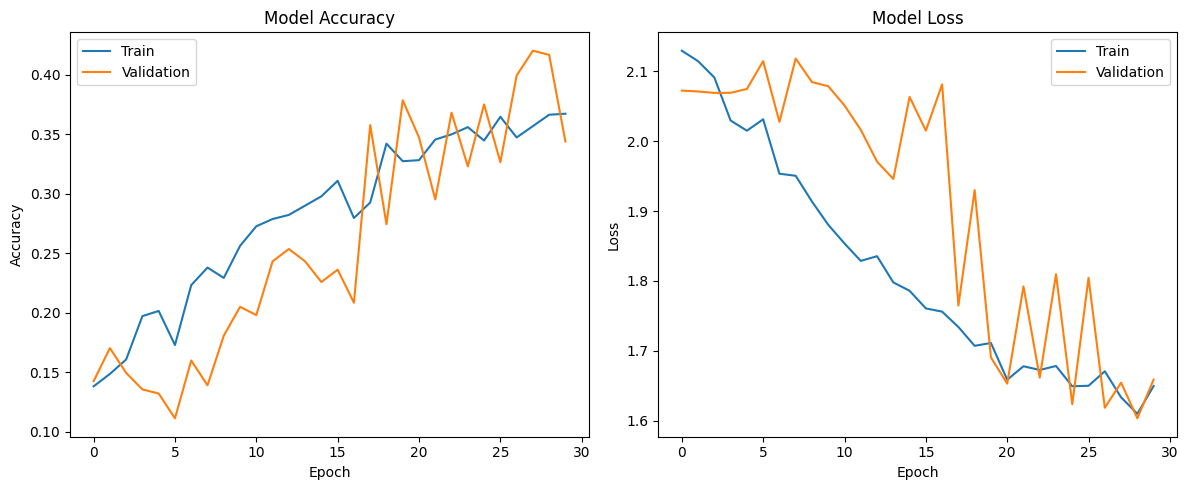

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


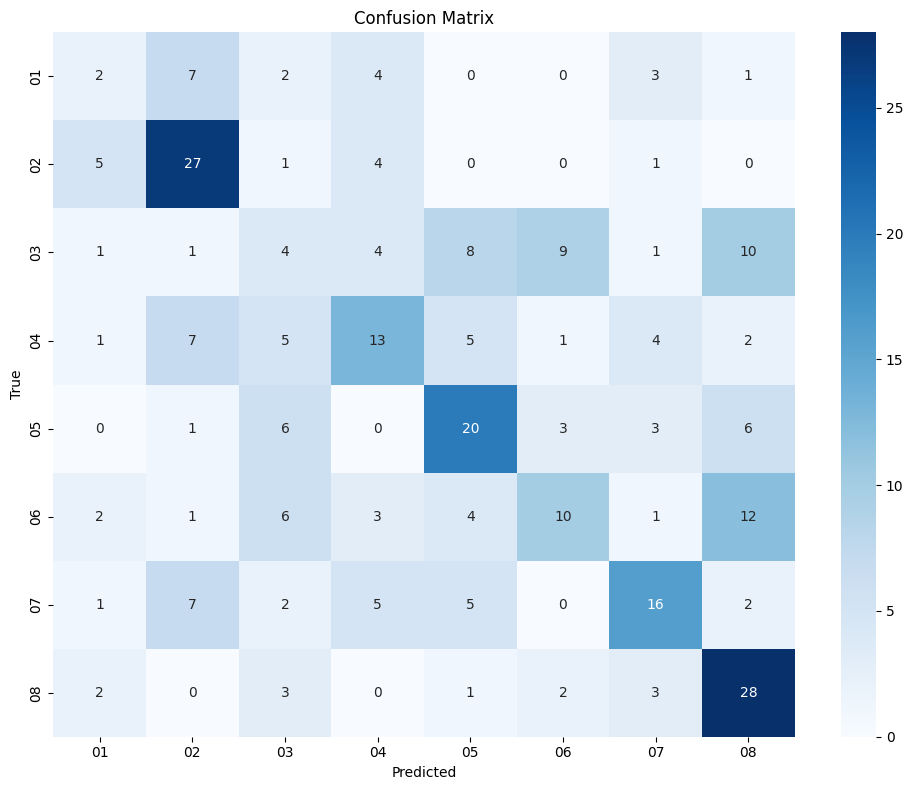

              precision    recall  f1-score     support
01             0.142857  0.105263  0.121212   19.000000
02             0.529412  0.710526  0.606742   38.000000
03             0.137931  0.105263  0.119403   38.000000
04             0.393939  0.342105  0.366197   38.000000
05             0.465116  0.512821  0.487805   39.000000
06             0.400000  0.256410  0.312500   39.000000
07             0.500000  0.421053  0.457143   38.000000
08             0.459016  0.717949  0.560000   39.000000
accuracy       0.416667  0.416667  0.416667    0.416667
macro avg      0.378534  0.396424  0.378875  288.000000
weighted avg   0.394737  0.416667  0.396650  288.000000

=== Training GRU Model ===


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 228, 40, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 228, 40, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 114, 20, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 114, 20, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 114, 20, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 57, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,669,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,764,296 (18.17 MB)

 Trainable params: 4,764,104 (18.17 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.1363 - loss: 2.3430
Epoch 1: val_accuracy improved from -inf to 0.13889, saving model to models/gru_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 233ms/step - accuracy: 0.1365 - loss: 2.3412 - val_accuracy: 0.1389 - val_loss: 2.1500 - learning_rate: 0.0010
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.1536 - loss: 2.1410
Epoch 2: val_accuracy did not improve from 0.13889
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 0.1535 - loss: 2.1416 - val_accuracy: 0.0833 - val_loss: 2.2163 - learning_rate: 0.0010
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.1767 - loss: 2.1279
Epoch 3: val_accuracy did not improve from 0.13889
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.1767 - loss: 2.1273 - val_accuracy: 0.1319 - val_loss: 2.1256 - learning_rate: 0.0010
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.1872 - loss: 2.1042
Epoch 4: val_accuracy improved from 0.13889 to 0.15278, saving model to models/gru_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.1870 - loss: 2.1042 - val_accuracy: 0.1528 - val_loss: 2.1886 - learning_rate: 0.0010
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.1907 - loss: 2.0786
Epoch 5: val_accuracy improved from 0.15278 to 0.20139, saving model to models/gru_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.1906 - loss: 2.0782 - val_accuracy: 0.2014 - val_loss: 2.2848 - learning_rate: 0.0010
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.1823 - loss: 2.0582
Epoch 6: val_accuracy did not improve from 0.20139
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - accuracy: 0.1826 - loss: 2.0579 - val_accuracy: 0.1354 - val_loss: 2.3677 - learning_rate: 0.0010
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.2182 - loss: 1.9980
Epoch 7: val_accuracy did not improve from 0.20139
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.2178 - loss: 1.9981 - val_accuracy: 0.1076 - val_loss: 2.1411 - learning_rate: 0.0010
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.2150 - loss: 1.9766
Epoch 8: val_accuracy did not improve from 0.20139

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.2152 - loss: 1.9760 - val_accurac

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 229ms/step - accuracy: 0.2417 - loss: 1.9069 - val_accuracy: 0.2188 - val_loss: 2.0713 - learning_rate: 2.0000e-04
Epoch 14/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.2801 - loss: 1.8867
Epoch 14: val_accuracy did not improve from 0.21875
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.2796 - loss: 1.8866 - val_accuracy: 0.2188 - val_loss: 2.0423 - learning_rate: 2.0000e-04
Epoch 15/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.2773 - loss: 1.8803
Epoch 15: val_accuracy improved from 0.21875 to 0.24653, saving model to models/gru_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 224ms/step - accuracy: 0.2773 - loss: 1.8800 - val_accuracy: 0.2465 - val_loss: 2.0052 - learning_rate: 2.0000e-04
Epoch 16/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.2831 - loss: 1.8189
Epoch 16: val_accuracy did not improve from 0.24653
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.2833 - loss: 1.8189 - val_accuracy: 0.2396 - val_loss: 2.0026 - learning_rate: 2.0000e-04
Epoch 17/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.2764 - loss: 1.8584
Epoch 17: val_accuracy improved from 0.24653 to 0.25694, saving model to models/gru_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.2766 - loss: 1.8579 - val_accuracy: 0.2569 - val_loss: 1.9615 - learning_rate: 2.0000e-04
Epoch 18/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.2578 - loss: 1.8219
Epoch 18: val_accuracy improved from 0.25694 to 0.26736, saving model to models/gru_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.2582 - loss: 1.8219 - val_accuracy: 0.2674 - val_loss: 1.8441 - learning_rate: 2.0000e-04
Epoch 19/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.2304 - loss: 1.8495
Epoch 19: val_accuracy improved from 0.26736 to 0.29861, saving model to models/gru_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.2312 - loss: 1.8486 - val_accuracy: 0.2986 - val_loss: 1.8595 - learning_rate: 2.0000e-04
Epoch 20/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.2617 - loss: 1.8204
Epoch 20: val_accuracy did not improve from 0.29861
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.2620 - loss: 1.8198 - val_accuracy: 0.2986 - val_loss: 1.8248 - learning_rate: 2.0000e-04
Epoch 21/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.3223 - loss: 1.7921
Epoch 21: val_accuracy did not improve from 0.29861
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.3224 - loss: 1.7914 - val_accuracy: 0.2951 - val_loss: 1.7765 - learning_rate: 2.0000e-04
Epoch 22/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.3025 - loss: 1.7307
Epoch 22: val_accuracy improved from 0.29861 to 0.32292, saving model to models/gru_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.3027 - loss: 1.7310 - val_accuracy: 0.3229 - val_loss: 1.7880 - learning_rate: 2.0000e-04
Epoch 23/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.3055 - loss: 1.7575
Epoch 23: val_accuracy did not improve from 0.32292
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.3054 - loss: 1.7574 - val_accuracy: 0.2951 - val_loss: 1.7822 - learning_rate: 2.0000e-04
Epoch 24/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.2971 - loss: 1.7758
Epoch 24: val_accuracy did not improve from 0.32292
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - accuracy: 0.2972 - loss: 1.7753 - val_accuracy: 0.2951 - val_loss: 1.7878 - learning_rate: 2.0000e-04
Epoch 25/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.3365 - loss: 1.7311
Epoch 25: val_accuracy improved from 0.32292 to 0.32639, saving model to models/gru_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.3361 - loss: 1.7309 - val_accuracy: 0.3264 - val_loss: 1.7238 - learning_rate: 2.0000e-04
Epoch 26/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.3517 - loss: 1.7363
Epoch 26: val_accuracy did not improve from 0.32639
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 259ms/step - accuracy: 0.3515 - loss: 1.7362 - val_accuracy: 0.3125 - val_loss: 1.7344 - learning_rate: 2.0000e-04
Epoch 27/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.2814 - loss: 1.7403
Epoch 27: val_accuracy improved from 0.32639 to 0.35069, saving model to models/gru_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.2821 - loss: 1.7399 - val_accuracy: 0.3507 - val_loss: 1.7066 - learning_rate: 2.0000e-04
Epoch 28/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.3409 - loss: 1.6893
Epoch 28: val_accuracy improved from 0.35069 to 0.37153, saving model to models/gru_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.3406 - loss: 1.6898 - val_accuracy: 0.3715 - val_loss: 1.6941 - learning_rate: 2.0000e-04
Epoch 29/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.3190 - loss: 1.7067
Epoch 29: val_accuracy improved from 0.37153 to 0.38194, saving model to models/gru_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.3193 - loss: 1.7065 - val_accuracy: 0.3819 - val_loss: 1.6693 - learning_rate: 2.0000e-04
Epoch 30/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.3436 - loss: 1.6665
Epoch 30: val_accuracy improved from 0.38194 to 0.39236, saving model to models/gru_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.3438 - loss: 1.6665 - val_accuracy: 0.3924 - val_loss: 1.6843 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 29.
Training completed in 246.08 seconds
Test accuracy: 0.3819


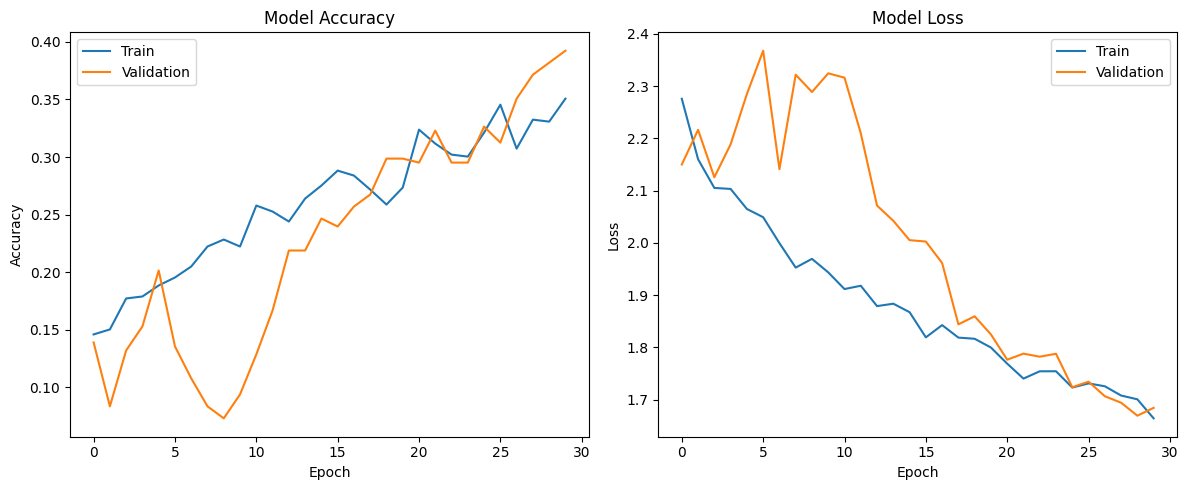

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


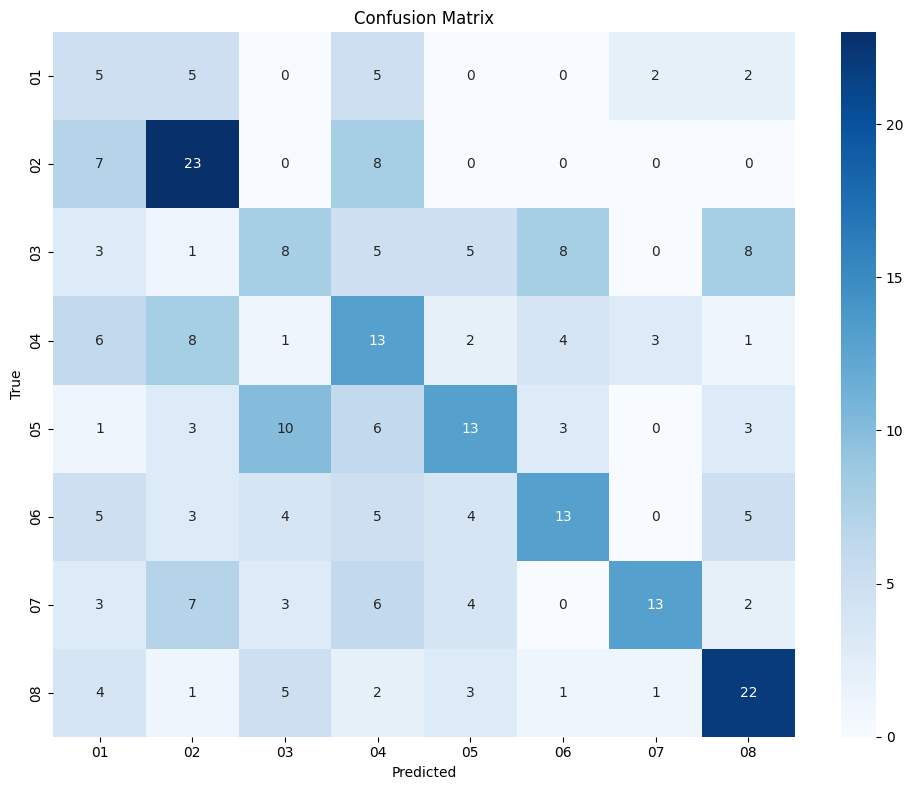

              precision    recall  f1-score     support
01             0.147059  0.263158  0.188679   19.000000
02             0.450980  0.605263  0.516854   38.000000
03             0.258065  0.210526  0.231884   38.000000
04             0.260000  0.342105  0.295455   38.000000
05             0.419355  0.333333  0.371429   39.000000
06             0.448276  0.333333  0.382353   39.000000
07             0.684211  0.342105  0.456140   38.000000
08             0.511628  0.564103  0.536585   39.000000
accuracy       0.381944  0.381944  0.381944    0.381944
macro avg      0.397447  0.374241  0.372422  288.000000
weighted avg   0.414614  0.381944  0.385145  288.000000

Best model: GRU with validation accuracy: 0.3924

Speech Emotion Recognition project completed successfully!
